In [1]:
import os
import json
from pathlib import Path

import numpy as np
import pandas as pd
from PIL import Image

import torch
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms as T
from torchvision.models.detection import fasterrcnn_resnet50_fpn_v2
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor

from tqdm import tqdm

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

In [2]:
BASE_DIR = "images"
JSON_FILE = os.path.join(BASE_DIR, "ece276c_json.json")
TRAIN_CSV = os.path.join(BASE_DIR, "train_annotations.csv")
VAL_CSV = os.path.join(BASE_DIR, "val_annotations.csv")
IMAGES_DIR = BASE_DIR
PRETRAINED_CKPT = "final_model.pth"
NUM_CLASSES = 2
BATCH_SIZE = 1
NUM_EPOCHS = 5
NUM_WORKERS = 0
LEARNING_RATE = 1e-4
WEIGHT_DECAY = 1e-4
TRAIN_RATIO = 0.8
FREEZE_BACKBONE = False

print(device)

cuda


In [3]:
data = []

with open(JSON_FILE, "r") as f:
    annotations = json.load(f)

for key, value in annotations.items():
    filename = value.get("filename")
    img_path = os.path.join(IMAGES_DIR, filename)
    if not os.path.exists(img_path):
        continue
    regions = value.get("regions", [])
    if not regions:
        continue
    for region in regions:
        shape = region.get("shape_attributes", {})
        x = shape.get("x")
        y = shape.get("y")
        width = shape.get("width")
        height = shape.get("height")
        if None in (x, y, width, height):
            continue
        xmin = x
        ymin = y
        xmax = x + width
        ymax = y + height
        data.append([filename, xmin, ymin, xmax, ymax])

cols = ["filename", "xmin", "ymin", "xmax", "ymax"]
df = pd.DataFrame(data, columns=cols)

indices = np.arange(len(df))
np.random.seed(42)
np.random.shuffle(indices)
split = int(len(df) * TRAIN_RATIO)
train_idx = indices[:split]
val_idx = indices[split:]

train_df = df.iloc[train_idx].reset_index(drop=True)
val_df = df.iloc[val_idx].reset_index(drop=True)

train_df.to_csv(TRAIN_CSV, index=False)
val_df.to_csv(VAL_CSV, index=False)

len(df), TRAIN_CSV, VAL_CSV

(91, 'images/train_annotations.csv', 'images/val_annotations.csv')

In [4]:
class NumberPlateDataset(Dataset):
    def __init__(self, csv_file, images_dir, transform=None):
        self.data_frame = pd.read_csv(csv_file)
        self.images_dir = images_dir
        self.transform = transform

    def __len__(self):
        return len(self.data_frame)

    def __getitem__(self, idx):
        row = self.data_frame.iloc[idx]
        img_path = os.path.join(self.images_dir, row["filename"])
        image = Image.open(img_path).convert("RGB")
        xmin = row["xmin"]
        ymin = row["ymin"]
        xmax = row["xmax"]
        ymax = row["ymax"]
        boxes = torch.tensor([[xmin, ymin, xmax, ymax]], dtype=torch.float32)
        labels = torch.tensor([1], dtype=torch.int64)
        target = {"boxes": boxes, "labels": labels}
        if self.transform is not None:
            image = self.transform(image)
        return image, target


def collate_fn(batch):
    images, targets = list(zip(*batch))
    return list(images), list(targets)


train_transform = T.Compose([T.ToTensor()])
val_transform = T.Compose([T.ToTensor()])

train_dataset = NumberPlateDataset(TRAIN_CSV, IMAGES_DIR, transform=train_transform)
val_dataset = NumberPlateDataset(VAL_CSV, IMAGES_DIR, transform=val_transform)

train_loader = DataLoader(
    train_dataset,
    batch_size=BATCH_SIZE,
    shuffle=True,
    collate_fn=collate_fn,
    num_workers=NUM_WORKERS,
    pin_memory=True if device.type == "cuda" else False,
)

val_loader = DataLoader(
    val_dataset,
    batch_size=BATCH_SIZE,
    shuffle=False,
    collate_fn=collate_fn,
    num_workers=NUM_WORKERS,
    pin_memory=True if device.type == "cuda" else False,
)

len(train_dataset), len(val_dataset)


(72, 19)

In [5]:
model = fasterrcnn_resnet50_fpn_v2(weights="DEFAULT")
in_features = model.roi_heads.box_predictor.cls_score.in_features
model.roi_heads.box_predictor = FastRCNNPredictor(in_features, NUM_CLASSES)

if os.path.exists(PRETRAINED_CKPT):
    state_dict = torch.load(PRETRAINED_CKPT, map_location="cpu")
    missing, unexpected = model.load_state_dict(state_dict, strict=False)
else:
    missing, unexpected = [], []

if FREEZE_BACKBONE:
    for param in model.backbone.parameters():
        param.requires_grad = False
else:
    for param in model.parameters():
        param.requires_grad = True

model.to(device)

params = [p for p in model.parameters() if p.requires_grad]
optimizer = optim.AdamW(params, lr=LEARNING_RATE, weight_decay=WEIGHT_DECAY)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=3, gamma=0.1)

len(params), missing, unexpected

(209, [], [])

In [6]:
def train_one_epoch(model, optimizer, data_loader, device):
    model.train()
    epoch_loss = 0.0
    for images, targets in tqdm(data_loader):
        images = [img.to(device, non_blocking=True) for img in images]
        targets = [{k: v.to(device, non_blocking=True) for k, v in t.items()} for t in targets]
        loss_dict = model(images, targets)
        loss = sum(loss for loss in loss_dict.values())
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        epoch_loss += loss.item()
        del images, targets, loss_dict, loss
        if device.type == "cuda":
            torch.cuda.empty_cache()
    return epoch_loss / max(1, len(data_loader))


@torch.no_grad()
def evaluate_loss(model, data_loader, device):
    model.train()
    epoch_loss = 0.0
    for images, targets in tqdm(data_loader):
        images = [img.to(device, non_blocking=True) for img in images]
        targets = [{k: v.to(device, non_blocking=True) for k, v in t.items()} for t in targets]
        loss_dict = model(images, targets)
        loss = sum(loss for loss in loss_dict.values())
        epoch_loss += loss.item()
        del images, targets, loss_dict, loss
        if device.type == "cuda":
            torch.cuda.empty_cache()
    return epoch_loss / max(1, len(data_loader))


best_val_loss = float("inf")
save_path = "finetuned_model.pth"

for epoch in range(NUM_EPOCHS):
    train_loss = train_one_epoch(model, optimizer, train_loader, device)
    val_loss = evaluate_loss(model, val_loader, device)
    scheduler.step()
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        torch.save(model.state_dict(), save_path)
    print("epoch", epoch + 1, "train_loss", train_loss, "val_loss", val_loss, "best_val_loss", best_val_loss)


 24%|██▎       | 17/72 [00:11<00:36,  1.49it/s]


KeyboardInterrupt: 

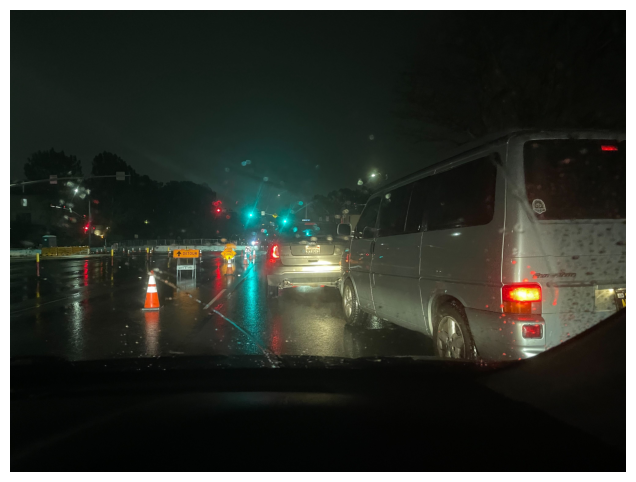

In [14]:
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from PIL import Image

@torch.no_grad()
def visualize_prediction_on_path(model, img_path, transform=None, score_thresh=0.5):
    model.eval()
    img = Image.open(img_path).convert("RGB")
    if transform is not None:
        image = transform(img)
    else:
        image = T.ToTensor()(img)
    model_input = [image.to(device)]
    outputs = model(model_input)
    output = outputs[0]
    img_np = image.permute(1, 2, 0).cpu().numpy()
    fig, ax = plt.subplots(1, 1, figsize=(8, 6))
    ax.imshow(img_np)
    boxes = output["boxes"].cpu().numpy()
    scores = output["scores"].cpu().numpy()
    for (xmin, ymin, xmax, ymax), s in zip(boxes, scores):
        if s < score_thresh:
            continue
        rect = patches.Rectangle((xmin, ymin), xmax - xmin, ymax - ymin, linewidth=2, edgecolor="r", facecolor="none")
        ax.add_patch(rect)
        ax.text(xmin, ymin - 5, f"{s:.2f}", color="r", fontsize=8)
    plt.axis("off")
    plt.show()


test_image_path = "./images/IMG_1885.jpg"
visualize_prediction_on_path(model, test_image_path, transform=val_transform, score_thresh=0.5)


num_boxes: 1
scores: [0.77179646]
best_score: 0.771796464920044
crop_shape: (86, 115, 3)


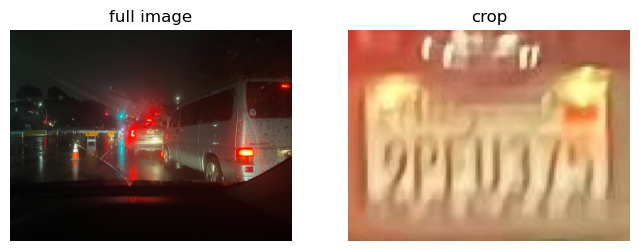

easyocr_raw: []
OCR:


''

In [17]:
import matplotlib.pyplot as plt

def detect_and_ocr_plate_easyocr_debug(model, img_path, transform=None, score_thresh=0.3):
    model.eval()
    img = Image.open(img_path).convert("RGB")
    if transform is not None:
        image = transform(img)
    else:
        image = T.ToTensor()(img)
    model_input = [image.to(device)]
    with torch.no_grad():
        outputs = model(model_input)
    output = outputs[0]
    boxes = output["boxes"].cpu().numpy()
    scores = output["scores"].cpu().numpy()
    print("num_boxes:", len(boxes))
    print("scores:", scores[:10])
    if len(boxes) == 0:
        print("no detections")
        return ""
    idx = int(np.argmax(scores))
    print("best_score:", float(scores[idx]))
    if scores[idx] < score_thresh:
        print("no confident detection")
        return ""
    xmin, ymin, xmax, ymax = boxes[idx].astype(int)
    img_np = image.permute(1, 2, 0).cpu().numpy()
    if img_np.max() <= 1.0:
        img_uint8 = (img_np * 255.0).astype("uint8")
    else:
        img_uint8 = img_np.astype("uint8")
    h, w = img_uint8.shape[:2]
    xmin = max(0, min(xmin, w - 1))
    xmax = max(0, min(xmax, w))
    ymin = max(0, min(ymin, h - 1))
    ymax = max(0, min(ymax, h))
    if xmax <= xmin or ymax <= ymin:
        print("invalid box after clamping:", xmin, ymin, xmax, ymax)
        return ""
    crop = img_uint8[ymin:ymax, xmin:xmax]
    print("crop_shape:", crop.shape)

    plt.figure(figsize=(8, 4))
    plt.subplot(1, 2, 1)
    plt.title("full image")
    plt.imshow(img_uint8)
    plt.axis("off")
    plt.subplot(1, 2, 2)
    plt.title("crop")
    plt.imshow(crop)
    plt.axis("off")
    plt.show()

    result = reader.readtext(crop, detail=0, paragraph=True)
    print("easyocr_raw:", result)
    if len(result) == 0:
        print("OCR:")
        return ""
    text = "".join(result).strip()
    print("OCR:", text)
    return text


test_image_path = "images/IMG_1882.jpg"
detect_and_ocr_plate_easyocr_debug(model, test_image_path, transform=val_transform, score_thresh=0.0)


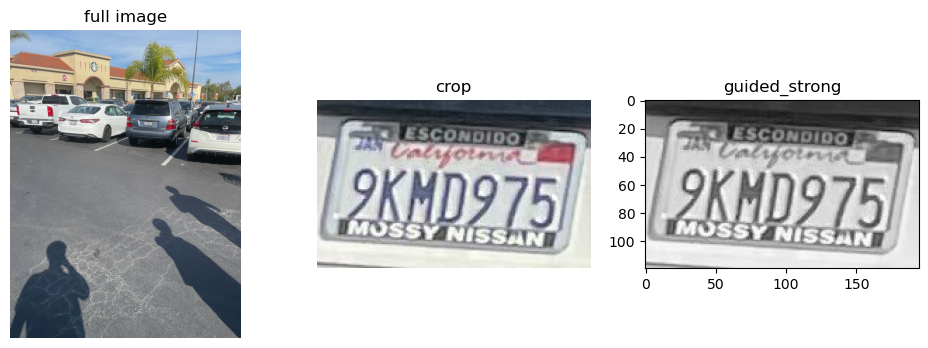

In [38]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from skimage.restoration import denoise_nl_means, estimate_sigma
from PIL import Image
import torchvision.transforms as T


def box_filter_cv(I, r):
    return cv2.boxFilter(I, -1, (r, r), borderType=cv2.BORDER_REFLECT)


def guided_filter_gray(I, p, r=8, eps=1e-3):
    I = I.astype(np.float32)
    p = p.astype(np.float32)
    mean_I = box_filter_cv(I, r)
    mean_p = box_filter_cv(p, r)
    mean_Ip = box_filter_cv(I * p, r)
    cov_Ip = mean_Ip - mean_I * mean_p
    mean_II = box_filter_cv(I * I, r)
    var_I = mean_II - mean_I * mean_I
    a = cov_Ip / (var_I + eps)
    b = mean_p - a * mean_I
    mean_a = box_filter_cv(a, r)
    mean_b = box_filter_cv(b, r)
    q = mean_a * I + mean_b
    return q


def apply_dip_filter_crop(crop, method="bilateral", strength="mild"):
    img = crop.copy()

    if method == "mean":
        if strength == "strong":
            k = 7
        else:
            k = 3
        out = cv2.blur(img, (k, k))

    elif method == "gaussian":
        if strength == "strong":
            k, sigma = 9, 2.0
        else:
            k, sigma = 5, 1.0
        if k % 2 == 0:
            k += 1
        out = cv2.GaussianBlur(img, (k, k), sigma)

    elif method == "bilateral":
        if strength == "strong":
            d = 11
            sigmaColor = 80
            sigmaSpace = 60
        else:
            d = 7
            sigmaColor = 40
            sigmaSpace = 20
        out = cv2.bilateralFilter(img, d=d, sigmaColor=sigmaColor, sigmaSpace=sigmaSpace)

    elif method == "guided":
        if strength == "strong":
            r = 12
            eps = 5e-4
        else:
            r = 6
            eps = 1e-3
        gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
        gray_norm = gray.astype(np.float32) / 255.0
        q = guided_filter_gray(gray_norm, gray_norm, r=r, eps=eps)
        q_uint8 = np.clip(q * 255.0, 0, 255).astype(np.uint8)
        out = cv2.cvtColor(q_uint8, cv2.COLOR_GRAY2RGB)

    elif method == "nlm":
        if strength == "strong":
            patch_size = 7
            patch_distance = 9
            h_factor = 1.2
        else:
            patch_size = 5
            patch_distance = 6
            h_factor = 0.8
        img_float = img.astype(np.float32) / 255.0
        sigma = np.mean(estimate_sigma(img_float, channel_axis=-1))
        patch_kw = dict(
            patch_size=patch_size,
            patch_distance=patch_distance,
            channel_axis=-1,
        )
        denoised = denoise_nl_means(img_float, h=h_factor * sigma, fast_mode=True, **patch_kw)
        out = np.clip(denoised * 255.0, 0, 255).astype(np.uint8)

    else:
        out = img

    return out


def detect_and_show_dip(model, img_path, method="bilateral", strength="mild",
                        transform=None, score_thresh=0.3):
    model.eval()
    img = Image.open(img_path).convert("RGB")
    if transform is not None:
        image = transform(img)
    else:
        image = T.ToTensor()(img)

    model_input = [image.to(device)]
    with torch.no_grad():
        outputs = model(model_input)
    output = outputs[0]
    boxes = output["boxes"].cpu().numpy()
    scores = output["scores"].cpu().numpy()

    if len(boxes) == 0:
        print("no detections")
        return
    idx = int(np.argmax(scores))
    if scores[idx] < score_thresh:
        print("no confident detection")
        return

    xmin, ymin, xmax, ymax = boxes[idx].astype(int)
    img_np = image.permute(1, 2, 0).cpu().numpy()
    if img_np.max() <= 1.0:
        img_uint8 = (img_np * 255.0).astype("uint8")
    else:
        img_uint8 = img_np.astype("uint8")

    h, w = img_uint8.shape[:2]
    xmin = max(0, min(xmin, w - 1))
    xmax = max(0, min(xmax, w))
    ymin = max(0, min(ymin, h - 1))
    ymax = max(0, min(ymax, h))
    if xmax <= xmin or ymax <= ymin:
        print("invalid box")
        return

    crop = img_uint8[ymin:ymax, xmin:xmax]
    crop_dip = apply_dip_filter_crop(crop, method=method, strength=strength)

    plt.figure(figsize=(12, 4))
    plt.subplot(1, 3, 1)
    plt.title("full image")
    plt.imshow(img_uint8)
    plt.axis("off")
    plt.subplot(1, 3, 2)
    plt.title("crop")
    plt.imshow(crop)
    plt.axis("off")
    plt.subplot(1, 3, 3)
    plt.title(f"{method}_{strength}")
    plt.imshow(crop_dip)
    plt.show()


# example:
detect_and_show_dip(model, "images/IMG_1859.jpg",
                    method="guided", strength="strong",
                    transform=val_transform, score_thresh=0.0)


In [39]:
import numpy as np

def box_iou(a, b):
    ax1, ay1, ax2, ay2 = a
    bx1, by1, bx2, by2 = b
    inter_x1 = max(ax1, bx1)
    inter_y1 = max(ay1, by1)
    inter_x2 = min(ax2, bx2)
    inter_y2 = min(ay2, by2)
    inter_w = max(0.0, inter_x2 - inter_x1)
    inter_h = max(0.0, inter_y2 - inter_y1)
    inter = inter_w * inter_h
    area_a = max(0.0, ax2 - ax1) * max(0.0, ay2 - ay1)
    area_b = max(0.0, bx2 - bx1) * max(0.0, by2 - by1)
    union = area_a + area_b - inter
    if union <= 0:
        return 0.0
    return inter / union


@torch.no_grad()
def evaluate_metrics(model, data_loader, device, score_thresh=0.5, iou_thresh=0.5):
    model.eval()
    ious = []
    detected = 0
    total = 0

    for images, targets in data_loader:
        images = [img.to(device) for img in images]
        outputs = model(images)

        for out, tgt in zip(outputs, targets):
            total += 1
            gt_boxes = tgt["boxes"].cpu().numpy()
            pred_boxes = out["boxes"].cpu().numpy()
            scores = out["scores"].cpu().numpy()

            if len(pred_boxes) == 0:
                continue

            idx = int(np.argmax(scores))
            if scores[idx] < score_thresh:
                continue

            pred = pred_boxes[idx]
            gt = gt_boxes[0]  # single box per image

            iou = box_iou(pred, gt)
            if iou >= iou_thresh:
                detected += 1
            ious.append(iou)

    avg_iou = float(np.mean(ious)) if len(ious) > 0 else 0.0
    det_rate = detected / max(1, total)
    return avg_iou, det_rate


In [40]:
train_losses = []
val_losses = []
val_ious = []
val_det_rates = []

best_val_loss = float("inf")
save_path = "finetuned_model.pth"

for epoch in range(NUM_EPOCHS):
    train_loss = train_one_epoch(model, optimizer, train_loader, device)
    val_loss = evaluate_loss(model, val_loader, device)
    avg_iou, det_rate = evaluate_metrics(model, val_loader, device,
                                         score_thresh=0.5, iou_thresh=0.5)
    scheduler.step()

    train_losses.append(train_loss)
    val_losses.append(val_loss)
    val_ious.append(avg_iou)
    val_det_rates.append(det_rate)

    if val_loss < best_val_loss:
        best_val_loss = val_loss
        torch.save(model.state_dict(), save_path)

    print(
        f"epoch {epoch+1}/{NUM_EPOCHS} "
        f"train_loss={train_loss:.4f} val_loss={val_loss:.4f} "
        f"avg_iou={avg_iou:.4f} det_rate={det_rate:.4f}"
    )


100%|██████████| 19/19 [00:05<00:00,  3.28it/s]


epoch 1/5 train_loss=0.0350 val_loss=0.0771 avg_iou=0.5796 det_rate=0.6842


100%|██████████| 19/19 [00:06<00:00,  3.15it/s]


epoch 2/5 train_loss=0.0314 val_loss=0.0761 avg_iou=0.5796 det_rate=0.6842


100%|██████████| 19/19 [00:05<00:00,  3.20it/s]


epoch 3/5 train_loss=0.0323 val_loss=0.0793 avg_iou=0.5797 det_rate=0.6842


100%|██████████| 19/19 [00:05<00:00,  3.27it/s]


epoch 4/5 train_loss=0.0314 val_loss=0.0753 avg_iou=0.5797 det_rate=0.6842


100%|██████████| 19/19 [00:05<00:00,  3.28it/s]


epoch 5/5 train_loss=0.0319 val_loss=0.0758 avg_iou=0.5793 det_rate=0.6842


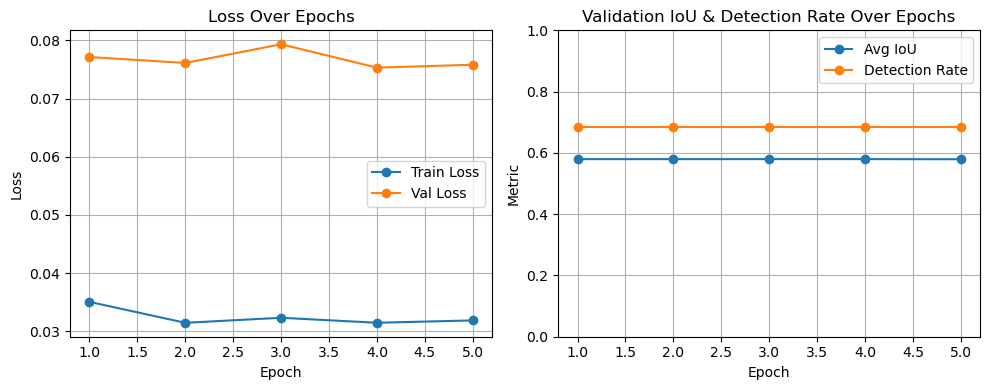

In [41]:
import matplotlib.pyplot as plt

epochs = range(1, len(train_losses) + 1)

fig, axes = plt.subplots(1, 2, figsize=(10, 4))

# left: loss
axes[0].plot(epochs, train_losses, marker="o", label="Train Loss")
axes[0].plot(epochs, val_losses, marker="o", label="Val Loss")
axes[0].set_xlabel("Epoch")
axes[0].set_ylabel("Loss")
axes[0].set_title("Loss Over Epochs")
axes[0].legend()
axes[0].grid(True)

# right: IoU and detection rate
axes[1].plot(epochs, val_ious, marker="o", label="Avg IoU")
axes[1].plot(epochs, val_det_rates, marker="o", label="Detection Rate")
axes[1].set_xlabel("Epoch")
axes[1].set_ylabel("Metric")
axes[1].set_title("Validation IoU & Detection Rate Over Epochs")
axes[1].set_ylim(0.0, 1.0)
axes[1].legend()
axes[1].grid(True)

plt.tight_layout()
plt.show()
